## Import the libraries

In [1]:
import string
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import pickle
from os.path import exists

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.utils import plot_model

# library to show the progress of loops.
from tqdm import tqdm
tqdm().pandas()

0it [00:00, ?it/s]


## Get and prepare the textual data

In [2]:
PATH_TO_TEXTS = 'dataset/Flickr8k_text/'
PATH_TO_IMAGES = 'dataset/Flickr8k_Dataset/Flicker8k_Dataset/'
PATH_TO_TRAIN_FILE_NAMES = PATH_TO_TEXTS + 'Flickr_8k.trainImages.txt'
PATH_TO_TEST_FILE_NAMES = PATH_TO_TEXTS + 'Flickr_8k.testImages.txt'

In [3]:
def get_text_from_file(file_path):
    with open(file_path, 'r') as f:
        text = f.read()
    return text

In [4]:
tokens = get_text_from_file(PATH_TO_TEXTS + 'Flickr8k.token.txt')
tokens[0:300]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the s'

In [5]:
tokens[-1]

'\n'

In [6]:
def get_all_descriptions(text):
    descriptions = [line.split('\t')[-1] for line in text.split('\n') if len(line) > 1]
    return descriptions

all_descriptions = get_all_descriptions(tokens)

print(f'Total number of descriptions in all_descriptions: {len(all_descriptions)}')
print('Expected number of descriptions: ' + str(len(tokens.split("\n"))-1))

Total number of descriptions in all_descriptions: 40460
Expected number of descriptions: 40460


In [7]:
all_descriptions[0:7]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .']

In [8]:
def get_all_file_names(text):
    lines = text.split('\n')
    reference = ''
    files = []

    for line in lines:
        file_name = line.split('#')[0]
        if reference != (file_name := line.split('#')[0]) and (len(file_name) > 1):
            files.append(file_name)
            reference = file_name

    return files

all_file_names = get_all_file_names(tokens)

print(f'Number of different file names: {len(all_file_names)}')
# There are 5 descriptions per file
print(f'Expect number of file names: {int(len(all_descriptions)/5)}')

Number of different file names: 8092
Expect number of file names: 8092


In [9]:
def clear_descriptions(descriptions):
    clear_descriptions = []
    table = str.maketrans('','',string.punctuation)

    for description in descriptions:
        description = description.replace('-', '').split(' ')
        description = [word.translate(table) for word in description]
        description = [word.lower() for word in description if (len(word) > 1) and (word.isalpha())]
        description = ' '.join(description)
        clear_descriptions.append(description)

    return clear_descriptions

all_descriptions = clear_descriptions(all_descriptions)
all_descriptions[0:7]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin',
 'black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road']

In [10]:
print(f'len(all_descriptions): {len(all_descriptions)}')

len(all_descriptions): 40460


In [11]:
def get_image_and_descriptions_dictionary(file_names, all_descriptions):
    image_and_descriptions_dict = {}

    for idx, file in enumerate(file_names):
        descriptions = []
        for i in range(5):
            descriptions.append(all_descriptions[i + idx*5])
        
        image_and_descriptions_dict[file] = descriptions
    
    return image_and_descriptions_dict

image_and_descriptions_dict = get_image_and_descriptions_dictionary(all_file_names, all_descriptions)

print(f'len(image_and_descriptions_dict): {len(image_and_descriptions_dict)}')
print(f'len(all_file_names): {len(all_file_names)}')

len(image_and_descriptions_dict): 8092
len(all_file_names): 8092


In [12]:
print(all_file_names[0])
print(all_descriptions[:5])

1000268201_693b08cb0e.jpg
['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [13]:
image_and_descriptions_dict['1000268201_693b08cb0e.jpg']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [14]:
print(all_file_names[-1])
print(all_descriptions[-5:])

997722733_0cb5439472.jpg
['man in pink shirt climbs rock face', 'man is rock climbing high in the air', 'person in red shirt climbing up rock face covered in assist handles', 'rock climber in red shirt', 'rock climber practices on rock climbing wall']


In [15]:
image_and_descriptions_dict['997722733_0cb5439472.jpg']

['man in pink shirt climbs rock face',
 'man is rock climbing high in the air',
 'person in red shirt climbing up rock face covered in assist handles',
 'rock climber in red shirt',
 'rock climber practices on rock climbing wall']

### Check for inconsistencies in the dataset

In [16]:
def check_missing_files(files_dictionary):
    missing_files = []
    cnt = 0

    for file in files_dictionary:
        if not exists(PATH_TO_IMAGES+file):
            missing_files.append(file)
            cnt += 1
            print(f'File not found: {file}')
    if cnt == 0:
        print('There are no missing files')
        return None
    else:
        print(f'Total missing files: {cnt}')
        return missing_files

In [17]:
missing_files = check_missing_files(image_and_descriptions_dict)

File not found: 2258277193_586949ec62.jpg.1
Total missing files: 1


Drop the dictionary entry of the missing file

In [18]:
for file in missing_files:
    image_and_descriptions_dict.pop(file)

In [19]:
check_missing_files(image_and_descriptions_dict)

There are no missing files


Update the variables

In [20]:
print(len(all_file_names))
all_file_names = [key for key in image_and_descriptions_dict]
print(len(all_file_names))

8092
8091


In [21]:
print(len(all_descriptions))
all_descriptions = []
for key in image_and_descriptions_dict:
    for description in image_and_descriptions_dict[key]:
        all_descriptions.append(description)
print(len(all_descriptions))

40460
40455


### Get the vocabulary

In [22]:
def get_vocabulary(all_descriptions):
    vocabulary = set()
    for description in all_descriptions:
        for word in description.split():
            if len(word) > 1:
                vocabulary.add(word)
    return list(vocabulary)

vocabulary = get_vocabulary(all_descriptions)
print(f'len(vocabulary): {len(vocabulary)}')
vocabulary[0:10]

len(vocabulary): 8763


['sunbathing',
 'an',
 'hillside',
 'smoky',
 'bmw',
 'soaked',
 'referee',
 'flautist',
 'twopiece',
 'determination']

In [23]:
files_test_raw = get_all_file_names(get_text_from_file(PATH_TO_TEST_FILE_NAMES))
files_test = [file for file in files_test_raw if file not in missing_files]
print(f'len(files_test_raw): {len(files_test_raw)}')
print(f'len(files_test): {len(files_test)}')
files_test[0:3]

len(files_test_raw): 1000
len(files_test): 1000


['3385593926_d3e9c21170.jpg',
 '2677656448_6b7e7702af.jpg',
 '311146855_0b65fdb169.jpg']

In [24]:
files_train_raw = get_all_file_names(get_text_from_file(PATH_TO_TRAIN_FILE_NAMES))
files_train = [file for file in files_train_raw if file not in missing_files]
print(f'len(files_train_raw): {len(files_train_raw)}')
print(f'len(files_train): {len(files_train)}')
files_train[0:3]

len(files_train_raw): 6000
len(files_train): 6000


['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg']

## Extract features using Xception model

In [25]:
def xception_features(img_files):
        model = Xception(include_top=False, pooling='avg')
        features = {}
        
        for img in tqdm(img_files):
            file_path = PATH_TO_IMAGES + img
            image = Image.open(file_path)
        
            # Adjust the image to fit in the pre-trained model
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
        
            # image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
        
            feature = model.predict(image)
            features[img] = feature
        return features

In [26]:
# features = xception_features(all_file_names)

### Save/Load the features

In [27]:
# with open('features.pkl', 'wb') as f:
#     pickle.dump(features, f)

In [28]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

### Prepare training data

In [29]:
train_dict = {key: image_and_descriptions_dict[key] for key in files_train}
all_train_descriptions = []
for key in train_dict:
    key_descriptions = []
    for description in train_dict[key]:
        description = 'start_description ' + description + ' end_description'
        all_train_descriptions.append(description)
        key_descriptions.append(description)
    train_dict[key] = key_descriptions

In [30]:
all_train_descriptions[0]

'start_description black dog is running after white dog in the snow end_description'

In [31]:
train_features = {key: features[key] for key in files_train}

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_train_descriptions)

### Get the maximum length of the descriptions

In [33]:
vocabulary_lenght = len(tokenizer.word_index) + 1
print(f'vocabulary_lenght: {vocabulary_lenght}')

vocabulary_lenght: 7578


In [34]:
descriptions_max_length = 0
for description in all_descriptions:
    if len(description.split()) > descriptions_max_length:
        descriptions_max_length = len(description.split())

print(f"descriptions_max_length: {descriptions_max_length}")

descriptions_max_length: 32


In [35]:
test_descriptions = [image_and_descriptions_dict[key] for key in files_test]

In [36]:
test_descriptions

[['the dogs are in the snow in front of fence',
  'the dogs play on the snow',
  'two brown dogs playfully fight in the snow',
  'two brown dogs wrestle in the snow',
  'two dogs playing in the snow'],
 ['brown and white dog swimming towards some in the pool',
  'dog in swimming pool swims toward sombody we cannot see',
  'dog swims in pool near person',
  'small dog is paddling through the water in pool',
  'the small brown and white dog is in the pool'],
 ['man and woman in festive costumes dancing',
  'man and woman with feathers on her head dance',
  'man and woman wearing decorative costumes and dancing in crowd of onlookers',
  'one performer wearing feathered headdress dancing with another performer in the streets',
  'two people are dancing with drums on the right and crowd behind them'],
 ['couple of people sit outdoors at table with an umbrella and talk',
  'three people are sitting at an outside picnic bench with an umbrella',
  'three people sit at an outdoor cafe',
  'thre

# HERE

In [37]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]         

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocabulary_lenght)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [38]:
[a,b],c = next(data_generator(train_dict, features, tokenizer, descriptions_max_length))
a.shape, b.shape, c.shape

((57, 2048), (57, 32), (57, 7578))

In [39]:
# features from the CNN model squeezed from 2048 to 256 nodes
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# LSTM sequence model
inputs2 = Input(shape=(descriptions_max_length,))
se1 = Embedding(vocabulary_lenght, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Merging both models
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocabulary_lenght, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [40]:
model = load_model('models/my_model04.01_24.h5')

In [43]:
epochs = 6
steps = len(train_dict)

for i in range(epochs):
    generator = data_generator(train_dict, train_features, tokenizer, descriptions_max_length)
    model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/my_model04.01_" + str(i+25) + ".h5")

6000/6000 [==============================] - 1465s 244ms/step - loss: 2.1752


In [44]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [45]:
def get_prediction(file):
    img_path = PATH_TO_IMAGES + file
    # model = load_model('models/my_model_9.h5')
    xception_model = Xception(include_top=False, pooling="avg")

    photo = extract_features(img_path, xception_model)
    img = Image.open(img_path)

    description = generate_desc(model, tokenizer, photo, descriptions_max_length)
    print("\n\n")
    print(description[18:-3])
    plt.imshow(img)
    plt.show()

In [46]:
files_test[0:10]

['3385593926_d3e9c21170.jpg',
 '2677656448_6b7e7702af.jpg',
 '311146855_0b65fdb169.jpg',
 '1258913059_07c613f7ff.jpg',
 '241347760_d44c8d3a01.jpg',
 '2654514044_a70a6e2c21.jpg',
 '2339106348_2df90aa6a9.jpg',
 '256085101_2c2617c5d0.jpg',
 '280706862_14c30d734a.jpg',
 '3072172967_630e9c69d0.jpg']




dog running in the snow 


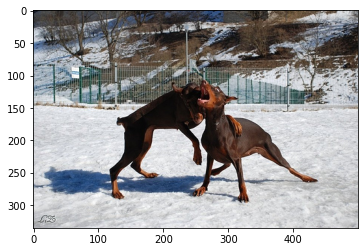

In [47]:
get_prediction('3385593926_d3e9c21170.jpg')




dog is jumping through the air 


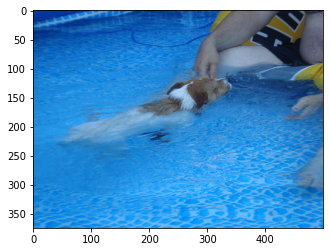

In [48]:
get_prediction('2677656448_6b7e7702af.jpg')




man in red shirt and sunglasses is walking through the street 


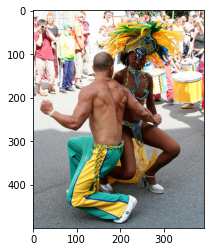

In [49]:
get_prediction('311146855_0b65fdb169.jpg')




man in black jacket is sitting on the curb of building 


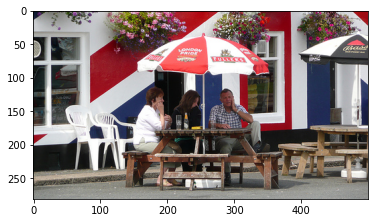

In [50]:
get_prediction('1258913059_07c613f7ff.jpg')




two football players are ready to advance the ball as sooner talk around him 


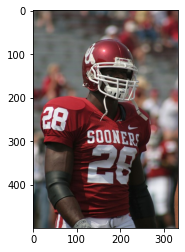

In [51]:
get_prediction('241347760_d44c8d3a01.jpg')




dog is running on the grass 


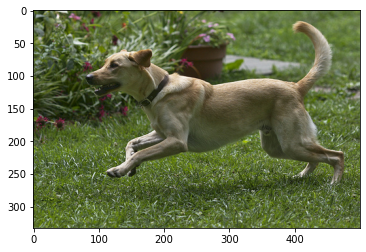

In [52]:
get_prediction('2654514044_a70a6e2c21.jpg')




man in red shirt and leather jacket and sunglasses is holding guitar 


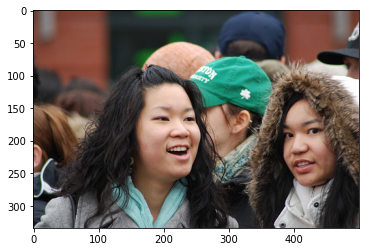

In [53]:
get_prediction('2339106348_2df90aa6a9.jpg')




dog is running on the grass 


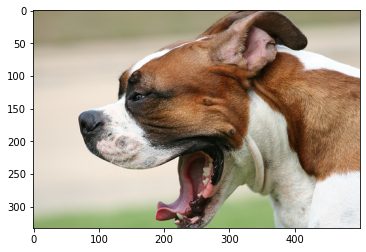

In [54]:
get_prediction('256085101_2c2617c5d0.jpg')




black dog is running through the grass 


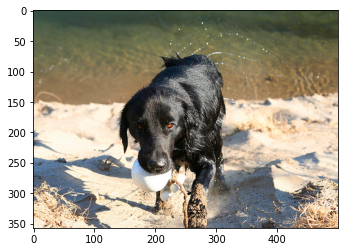

In [55]:
get_prediction('280706862_14c30d734a.jpg')




two men playing basketball 


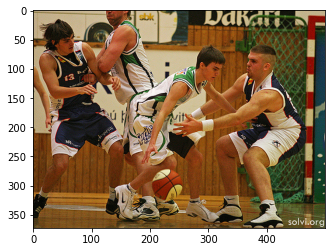

In [56]:
get_prediction('3072172967_630e9c69d0.jpg')